In [1]:
import os
from llava.model import LlavaLlamaForCausalLM, LlavaConfig
from transformers import AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    DEFAULT_IMAGE_PATCH_TOKEN,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    tokenizer_image_token,
    get_model_name_from_path,
    KeywordsStoppingCriteria,
)
from llava.model import *
from PIL import Image
import math
import json
from tqdm import tqdm
import shortuuid

/kuacc/users/oince22/.conda/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-04-27 17:35:39,597] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

In [4]:
model_path = "../sft_output_2"
model_name = "llava"
qlora_path = "../rlhf_model/checkpoint-40/adapter_model/lora_policy/"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

bits = 4
dtype = torch.bfloat16
compute_dtype = torch.bfloat16

model = LlavaLlamaForCausalLM.from_pretrained(
    model_path,
    device_map={"": "cuda:0"},
    torch_dtype=dtype,
    load_in_4bit=(bits == 4),
    load_in_8bit=(bits == 8),
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=(bits == 4),
        load_in_8bit=(bits == 8),
        llm_int8_threshold=6.0,
        llm_int8_skip_modules=["mm_projector", "lm_head"],
        llm_int8_has_fp16_weight=False,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    ),
)

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]
Some weights of the model checkpoint at ../sft_output_2 were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.10.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.19.self_attn.v_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.4.self_attn.v_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.6.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.13.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 

In [6]:
model = PeftModel.from_pretrained(
    model,
    qlora_path,
)

In [7]:
mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
mm_use_im_patch_token = getattr(model.config, "mm_use_im_patch_token", True)
if mm_use_im_patch_token:
    tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens(
        [DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True
    )
model.resize_token_embeddings(len(tokenizer))

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device="cuda", dtype=compute_dtype)
image_processor = vision_tower.image_processor

In [24]:
class Args:
    def __init__(self):
        self.question_file = "./qa90_questions.jsonl"
        self.image_folder = "/datasets/COCO/val2014/"
        self.answers_file = "./qa90_llava_rlhf_answer.jsonl"
        self.test_prompt = ""
        self.image_folder = "/datasets/COCO/val2014/"
        self.question_file = "./qa90_questions.jsonl"
        self.conv_mode = "llava_v1"
        self.num_chunks = 1
        self.chunk_idx = 0
        self.temperature = 0.2
        self.top_p = None
        self.num_beams = 1
        self.short_eval = False
        self.image_aspect_ratio = "pad"
        self.test_prompt = "" #"\nAnswer the question using a single word or phrase."

args = Args()

In [25]:
questions = [
    json.loads(q) for q in open(args.question_file, "r")
]

questions = get_chunk(questions, args.num_chunks, args.chunk_idx)
answers_file = args.answers_file
os.makedirs(os.path.dirname(answers_file), exist_ok=True)
ans_file = open(answers_file, "w")

In [26]:
questions[0]

{'question_id': 0,
 'image': '000000441147.jpg',
 'text': 'What is the color of the two suitcases in the image?',
 'category': 'conv'}

In [28]:
nycc_example = {
    "question_id": 0x7FFFFFFF,
    "image": "/kuacc/users/oince22/hpc_run/NYCC/LLaVA-RLHF/data/explanation_images/b02b155d73330b40eed6cad9764b749f.jpg",
    "text": "Can you explain me the following cartoon caption? Caption: He's been sitting there since the French Revolution.",
    "category": "conv"
}
nycc_example

{'question_id': 2147483647,
 'image': '/kuacc/users/oince22/hpc_run/NYCC/LLaVA-RLHF/data/explanation_images/b02b155d73330b40eed6cad9764b749f.jpg',
 'text': "Can you explain me the following cartoon caption? Caption: He's been sitting there since the French Revolution.",
 'category': 'conv'}

In [29]:
def example(line):
    idx = line["question_id"]
    image_file = line["image"]

    qs = line["text"]
    cur_prompt = qs
    if model.config.mm_use_im_start_end:
        qs = (
            DEFAULT_IM_START_TOKEN
            + DEFAULT_IMAGE_TOKEN
            + DEFAULT_IM_END_TOKEN
            + "\n"
            + qs
        )
    else:
        qs = DEFAULT_IMAGE_TOKEN + "\n" + qs
    if args.test_prompt:
        qs += args.test_prompt
    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = (
        tokenizer_image_token(
            prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
        )
        .unsqueeze(0)
        .cuda()
    )

    if image_file.startswith("/"):
        image = Image.open(image_file)
    else:
        image = Image.open(os.path.join(args.image_folder, "COCO_val2014_" + image_file))
        
    image.show()

    if args.image_aspect_ratio == "pad":
        image = image.convert("RGB")

        def expand2square(pil_img, background_color):
            # print(background_color)
            width, height = pil_img.size
            if width == height:
                return pil_img
            elif width > height:
                result = Image.new(pil_img.mode, (width, width), background_color)
                result.paste(pil_img, (0, (width - height) // 2))
                return result
            else:
                result = Image.new(pil_img.mode, (height, height), background_color)
                result.paste(pil_img, ((height - width) // 2, 0))
                return result

        image = expand2square(
            image, tuple(int(x * 255) for x in image_processor.image_mean)
        )
    image_tensor = image_processor.preprocess(image, return_tensors="pt")[
        "pixel_values"
    ][0]

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    model.config.use_cache = True
    model.config.cache_shape = (2048,)
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids=input_ids,
            images=image_tensor.unsqueeze(0).to(dtype=compute_dtype).cuda(),
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature if args.temperature > 0 else 1.0,
            top_p=args.top_p,
            num_beams=args.num_beams,
            # no_repeat_ngram_size=3,
            max_new_tokens=64 if args.short_eval else 1024,
            # stopping_criteria=[stopping_criteria],
            use_cache=True,
        )

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (
        (input_ids != output_ids[:, :input_token_len]).sum().item()
    )
    if n_diff_input_output > 0:
        print(
            f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids"
        )
    outputs = tokenizer.batch_decode(
        output_ids[:, input_token_len:], skip_special_tokens=True
    )[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]
    outputs = outputs.strip()
    print("Question:", qs)
    print("\nAnswer:", outputs)


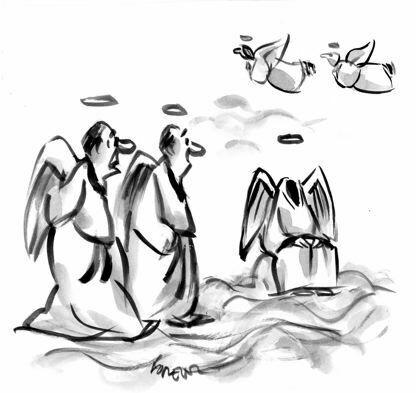

Question: <image>
Can you explain me the following cartoon caption? Caption: He's been sitting there since the French Revolution.

Answer: The joke is that the angels are sitting on the ground, which is a reference to the French Revolution, where the people were so angry that they were sitting on the ground. The angels are also sitting on the ground, but they are not angry, so it's a funny contrast.

Correct Explanation: During the french revolution, the ruling class was famously beheaded, similar to the headless angel sitting in this scene. The reason the angel has been siting there since the french revolution is because, presumably, they were a victim of the guillotine. The joke is funny in part because, presumably, the person would be given the head back in the afterlife, but they haven't been.


In [32]:
example(nycc_example)
print("\nCorrect Explanation:", "During the french revolution, the ruling class was famously beheaded, similar to the headless angel sitting in this scene. The reason the angel has been siting there since the french revolution is because, presumably, they were a victim of the guillotine. The joke is funny in part because, presumably, the person would be given the head back in the afterlife, but they haven't been.")

In [10]:
for line in tqdm(questions):
    idx = line["question_id"]
    image_file = line["image"]

    qs = line["text"]
    cur_prompt = qs
    if model.config.mm_use_im_start_end:
        qs = (
            DEFAULT_IM_START_TOKEN
            + DEFAULT_IMAGE_TOKEN
            + DEFAULT_IM_END_TOKEN
            + "\n"
            + qs
        )
    else:
        qs = DEFAULT_IMAGE_TOKEN + "\n" + qs
    if args.test_prompt:
        qs += args.test_prompt
    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = (
        tokenizer_image_token(
            prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
        )
        .unsqueeze(0)
        .cuda()
    )

    image = Image.open(os.path.join(args.image_folder, "COCO_val2014_" + image_file))
    if args.image_aspect_ratio == "pad":
        image = image.convert("RGB")

        def expand2square(pil_img, background_color):
            # print(background_color)
            width, height = pil_img.size
            if width == height:
                return pil_img
            elif width > height:
                result = Image.new(pil_img.mode, (width, width), background_color)
                result.paste(pil_img, (0, (width - height) // 2))
                return result
            else:
                result = Image.new(pil_img.mode, (height, height), background_color)
                result.paste(pil_img, ((height - width) // 2, 0))
                return result

        image = expand2square(
            image, tuple(int(x * 255) for x in image_processor.image_mean)
        )
    image_tensor = image_processor.preprocess(image, return_tensors="pt")[
        "pixel_values"
    ][0]

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    model.config.use_cache = True
    model.config.cache_shape = (2048,)
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids=input_ids,
            images=image_tensor.unsqueeze(0).to(dtype=compute_dtype).cuda(),
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature if args.temperature > 0 else 1.0,
            top_p=args.top_p,
            num_beams=args.num_beams,
            # no_repeat_ngram_size=3,
            max_new_tokens=64 if args.short_eval else 1024,
            # stopping_criteria=[stopping_criteria],
            use_cache=True,
        )

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (
        (input_ids != output_ids[:, :input_token_len]).sum().item()
    )
    if n_diff_input_output > 0:
        print(
            f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids"
        )
    outputs = tokenizer.batch_decode(
        output_ids[:, input_token_len:], skip_special_tokens=True
    )[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]
    outputs = outputs.strip()

    ans_id = shortuuid.uuid()
    ans_file.write(
        json.dumps(
            {
                "question_id": idx,
                "prompt": cur_prompt,
                "text": outputs,
                "answer_id": ans_id,
                "model_id": model_name,
                "metadata": {},
            }
        )
        + "\n"
    )
    ans_file.flush()
ans_file.close()

100%|██████████| 90/90 [01:44<00:00,  1.17s/it]
